In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from imblearn.ensemble import BalancedBaggingClassifier
train = pd.read_csv("Downloads/DQTrain.csv")
test = pd.read_csv(r"/Users/ryanrakusin/Downloads/DQTest.csv")
train['MealPlan'] = train.MealPlan.str.replace(r"[^0-9]+",'')
train["MealPlan"] = pd.to_numeric(train["MealPlan"])
train['RoomType'] = train.RoomType.str.replace(r"[^0-9]+",'')
train["RoomType"] = pd.to_numeric(train["RoomType"])
train["MarketSegment"] = pd.Series(np.where(train.MarketSegment.values == 'Corporate', 1, 0),train.index)
train["BookingStatus"] = pd.Series(np.where(train.BookingStatus.values == 'Canceled', 1, 0),train.index)
train

<ipython-input-54-13b24c9f07ec>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  train['MealPlan'] = train.MealPlan.str.replace(r"[^0-9]+",'')
<ipython-input-54-13b24c9f07ec>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  train['RoomType'] = train.RoomType.str.replace(r"[^0-9]+",'')


,BookingID,LeadTime,ArrivalYear,ArrivalMonth,ArrivalDate,NumWeekendNights,NumWeekNights,MealPlan,Parking,RoomType,NumAdults,NumChildren,MarketSegment,RepeatedGuest,NumPrevCancellations,NumPreviousNonCancelled,AvgRoomPrice,SpecialRequests,BookingStatus
0,1,10,2018,3,31,0,1,1.0,0,1,1,0,1,0,0,0,95.00,0,1
1,2,116,2018,2,28,2,1,1.0,0,1,1,0,0,0,0,0,61.00,0,1
2,3,11,2018,7,25,1,2,1.0,0,1,2,1,0,0,0,0,129.75,1,0
3,4,3,2017,9,12,0,1,1.0,0,1,2,0,0,0,0,0,152.00,3,0
4,5,28,2018,3,7,1,3,1.0,0,1,2,0,0,0,0,0,87.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29015,29016,2,2018,11,21,1,2,1.0,0,1,1,0,0,0,0,0,100.67,1,0
29016,29017,18,2018,4,12,0,2,NaN,0,1,2,0,0,0,0,0,119.00,1,0
29017,29018,8,2017,9,29,0,3,1.0,0,1,1,0,1,0,0,0,65.00,0,0
29018,29019,20,2018,9,18,2,2,1.0,0,1,1,0,0,0,0,0,90.00,0,1


In [55]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
train['CancelRatio'] = train['NumPrevCancellations'] / (train['NumPreviousNonCancelled'] + train['NumPrevCancellations'])
train['CancelRatio'] = train['CancelRatio'].replace(np.nan, 0)
train['NumGuests'] = train['NumAdults'] + train['NumChildren']
train['Nights'] = train['NumWeekendNights'] + train['NumWeekNights']

train['Date'] = pd.to_datetime(train['ArrivalYear'].astype(str) + '-' + train['ArrivalMonth'].astype(str).str.zfill(2) + '-' + train['ArrivalDate'].astype(str).str.zfill(2), errors='coerce')
cat_features = ['MealPlan', 'Parking', 'RoomType', 'MarketSegment', 'RepeatedGuest']

# create the transformer for one-hot encoding
# calculate number of days since first date
train = train.sort_values(by='Date')
first_date = train['Date'].iloc[0]
train['DaysSinceFirst'] = (train['Date'] - first_date).dt.days

In [56]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)
train=train.dropna()
x = train.loc[:, (train.columns != 'BookingStatus') & (train.columns != 'BookingID') & (train.columns != 'Date')]
y = train.BookingStatus # Target variable
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1) # 70% training and 30% test
CT = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_features)],remainder='passthrough')
x_train = CT.fit_transform(x_train)
x_test = CT.transform(x_test)
# Split dataset into training set and test set
clf = DecisionTreeClassifier(criterion="entropy", random_state=5)
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

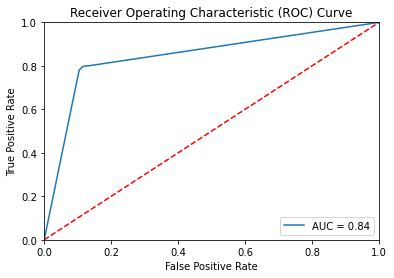

In [57]:
from sklearn.metrics import roc_curve, roc_auc_score

# make predictions on test data
y_pred_proba = clf.predict_proba(x_test)[:,1]

# calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# plot ROC curve
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Accuracy: 0.8580428954423592
Precision: 0.7813915191436805
F1 Score: 0.7818743563336765
Recall: 0.7823577906018137


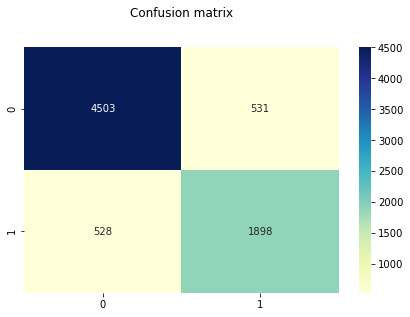

In [58]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names = [0,1] # Our diagnosis categories

fig, ax = plt.subplots()
# Setting up and visualizing the plot (do not worry about the code below!)
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') # Creating heatmap
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
from sklearn import tree
#tree.plot_tree(clf)

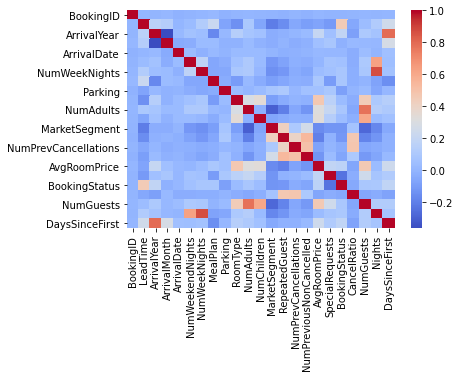

BookingStatus              1.000000
LeadTime                   0.452386
ArrivalYear                0.189561
DaysSinceFirst             0.186090
AvgRoomPrice               0.165365
Nights                     0.100442
NumGuests                  0.094195
NumWeekNights              0.088575
MealPlan                   0.088085
NumAdults                  0.087969
NumWeekendNights           0.061888
NumChildren                0.039264
RoomType                   0.035358
ArrivalDate                0.012961
BookingID                 -0.001129
ArrivalMonth              -0.013979
NumPrevCancellations      -0.033401
CancelRatio               -0.042983
NumPreviousNonCancelled   -0.063662
Parking                   -0.082415
RepeatedGuest             -0.113404
MarketSegment             -0.123802
SpecialRequests           -0.236206
Name: BookingStatus, dtype: float64


In [59]:
corr_matrix = train.corr()

# Visualize the correlation matrix
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

# Check the correlation between each feature and the target variable
corr_with_target = corr_matrix['BookingStatus'].sort_values(ascending=False)
print(corr_with_target)

In [60]:
#ADA boost model
from sklearn.ensemble import AdaBoostClassifier
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1)
model = abc.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8124664879356568
Precision: 0.7480204937121565
F1 Score: 0.6965950986770766


In [ ]:
# hypertune parameters with GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
clf = DecisionTreeClassifier(random_state=5)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
